In [1]:
# ==========================
# Cell 1 — Imports & Setup
# ==========================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

print("✅ All libraries imported successfully.")

✅ All libraries imported successfully.


In [2]:
# ==========================
# Cell 2 — Load Dataset
# ==========================

DATA_PATH = r"D:\CitizenSafetyAssistant\Accidents_data.csv"

df = pd.read_csv(DATA_PATH)
print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
df.head(3)


✅ Dataset loaded successfully!
Shape: (7728394, 46)
Columns: 46


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day


In [3]:
# ==========================
# Cell 3 — Coordinate Preservation
# ==========================

data = df.copy()

# Ensure coordinate columns exist
if 'End_Lat' not in data.columns:
    data['End_Lat'] = np.nan
if 'End_Lng' not in data.columns:
    data['End_Lng'] = np.nan

# Fill missing with start coordinates
data['End_Lat'] = data['End_Lat'].fillna(data['Start_Lat'])
data['End_Lng'] = data['End_Lng'].fillna(data['Start_Lng'])

print("✅ Coordinate columns fixed. Sample:")
print(data[['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng']].head(3))


✅ Coordinate columns fixed. Sample:
   Start_Lat  Start_Lng    End_Lat    End_Lng
0  39.865147 -84.058723  39.865147 -84.058723
1  39.928059 -82.831184  39.928059 -82.831184
2  39.063148 -84.032608  39.063148 -84.032608


In [ ]:
# ==========================
# Cell 4 — Cleaning & Feature Engineering
# ==========================

# Convert times
for col in ['Start_Time', 'End_Time']:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Duration (hours)
if {'Start_Time', 'End_Time'}.issubset(data.columns):
    data['Duration(hrs)'] = (data['End_Time'] - data['Start_Time']).dt.total_seconds() / 3600
    data['Duration(hrs)'] = data['Duration(hrs)'].clip(lower=0)
    data['Duration(hrs)'].fillna(data['Duration(hrs)'].median(), inplace=True)
else:
    data['Duration(hrs)'] = np.nan

# Temporal features
data['Hour'] = data['Start_Time'].dt.hour
data['DayOfWeek'] = data['Start_Time'].dt.dayofweek
data['Month'] = data['Start_Time'].dt.month

# Fill missing numerics with mean, categoricals with mode
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(include=['object', 'bool']).columns

for col in num_cols:
    data[col].fillna(data[col].mean(), inplace=True)
for col in cat_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

print("Cleaning complete. Sample numeric columns:")
print(data[num_cols].head(3))


✅ Cleaning complete. Sample numeric columns:
   Severity  Start_Lat  Start_Lng    End_Lat    End_Lng  Distance(mi)  \
0         3  39.865147 -84.058723  39.865147 -84.058723          0.01   
1         2  39.928059 -82.831184  39.928059 -82.831184          0.01   
2         2  39.063148 -84.032608  39.063148 -84.032608          0.01   

   Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
0            36.9      58.251048         91.0         29.68            10.0   
1            37.9      58.251048        100.0         29.65            10.0   
2            36.0      33.300000        100.0         29.67            10.0   

   Wind_Speed(mph)  Precipitation(in)  Duration(hrs)  Hour  DayOfWeek  Month  
0          7.68549           0.020000       5.233333   5.0        0.0    2.0  
1          7.68549           0.000000       0.500000   6.0        0.0    2.0  
2          3.50000           0.008407       0.500000   6.0        0.0    2.0  


In [5]:
# ==========================
# Cell 5 — Encode & Split
# ==========================

TARGET = 'Severity'
if TARGET not in data.columns:
    raise ValueError(f"❌ Target column '{TARGET}' not found!")

# Encode categoricals
le = LabelEncoder()
for col in data.select_dtypes(include=['object', 'bool']).columns:
    data[col] = le.fit_transform(data[col].astype(str))

# Define features & labels
X = data.drop(columns=[TARGET])
y = data[TARGET]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data ready for training.")
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


✅ Data ready for training.
Train shape: (6182715, 49) | Test shape: (1545679, 49)


In [ ]:
# ==========================
# Cell 6 — Training
# ==========================
from xgboost import XGBClassifier

# --- Handle datetime columns ---
datetime_cols = ["Start_Time", "End_Time"]

# Convert to datetime just in case
for col in datetime_cols:
    X_train[col] = pd.to_datetime(X_train[col], errors='coerce')
    X_test[col] = pd.to_datetime(X_test[col], errors='coerce')

# ---  Create duration feature (in hours) ---
X_train["Duration_hr"] = (X_train["End_Time"] - X_train["Start_Time"]).dt.total_seconds() / 3600
X_test["Duration_hr"] = (X_test["End_Time"] - X_test["Start_Time"]).dt.total_seconds() / 3600

# ---  Optional: extract useful temporal info ---
X_train["Start_Hour"] = X_train["Start_Time"].dt.hour
X_train["Start_Day"] = X_train["Start_Time"].dt.dayofweek
X_train["Start_Month"] = X_train["Start_Time"].dt.month

X_test["Start_Hour"] = X_test["Start_Time"].dt.hour
X_test["Start_Day"] = X_test["Start_Time"].dt.dayofweek
X_test["Start_Month"] = X_test["Start_Time"].dt.month

# ---  Drop original datetime columns ---
X_train = X_train.drop(columns=datetime_cols)
X_test = X_test.drop(columns=datetime_cols)

# ---  Re-align labels to start from 0 ---
y_train = y_train - y_train.min()
y_test = y_test - y_test.min()

# ---  Train XGBoost ---
xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)
print("\nModel trained successfully!")


🚀 Training XGBoost model...

✅ Model trained successfully!


In [7]:
# # =========================
# # 📦 Cell 6.5: Install Visualization Libraries
# # =========================
# !pip install matplotlib seaborn

🎯 Model Accuracy: 0.9365

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78     13473
           1       0.95      0.98      0.96   1231396
           2       0.88      0.82      0.85    259868
           3       0.95      0.53      0.68     40942

    accuracy                           0.94   1545679
   macro avg       0.90      0.77      0.82   1545679
weighted avg       0.94      0.94      0.93   1545679



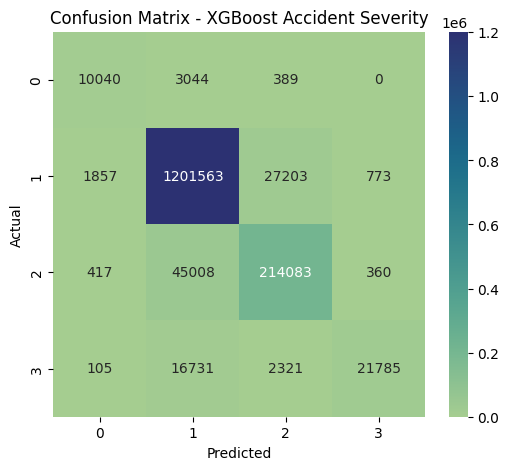

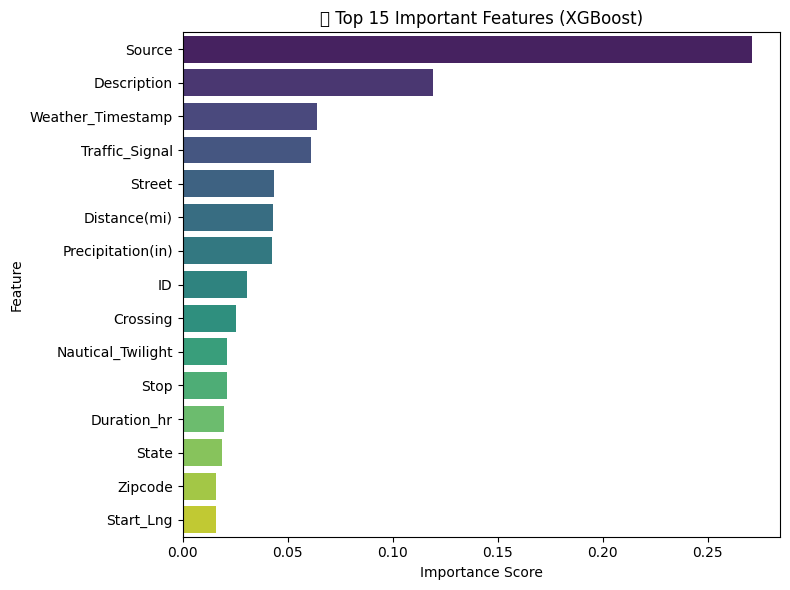

In [8]:
# =========================
# 📊 Cell 7: Model Evaluation + Feature Importance
# =========================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ 1. Predictions
y_pred = xgb_model.predict(X_test)

# ✅ 2. Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy: {acc:.4f}\n")

print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# ✅ 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - XGBoost Accident Severity")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ✅ 4. Feature Importance
importances = xgb_model.feature_importances_
feature_names = X_train.columns

feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:15]
feat_df = np.array(feat_imp, dtype=object)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_df[:, 1].astype(float), y=feat_df[:, 0], palette="viridis")
plt.title("🔥 Top 15 Important Features (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [9]:
# !pip install folium

In [ ]:
# =========================
# Cell 8: Accident Hotspot Map Visualization
# =========================

import folium
from folium.plugins import HeatMap

# Take a smaller subset for visualization (too large → performance issues)
subset = X_test.copy()
subset['Severity'] = y_pred
subset['Start_Lat'] = df.loc[subset.index, 'Start_Lat']
subset['Start_Lng'] = df.loc[subset.index, 'Start_Lng']

#Drop NaNs in lat/long
subset = subset.dropna(subset=['Start_Lat', 'Start_Lng'])

#Base map centered around median coordinates
center_lat, center_lng = subset['Start_Lat'].median(), subset['Start_Lng'].median()
m = folium.Map(location=[center_lat, center_lng], zoom_start=6, tiles="CartoDB positron")

#Heatmap showing accident density
HeatMap(data=subset[['Start_Lat', 'Start_Lng']], radius=6, blur=12).add_to(m)

#Color-coded markers for predicted severity (sample for clarity)
severity_colors = {1: "green", 2: "orange", 3: "red", 4: "darkred"}
sample = subset.sample(500, random_state=42)

for _, row in sample.iterrows():
    folium.CircleMarker(
        location=[row['Start_Lat'], row['Start_Lng']],
        radius=4,
        color=severity_colors.get(row['Severity'], "blue"),
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

#Save map
m.save("Accident_Hotspots.html")
print("Interactive map saved as 'Accident_Hotspots.html' — open it in your browser.")


✅ Interactive map saved as 'Accident_Hotspots.html' — open it in your browser.


In [ ]:
# =========================
# Cell 9: Real-Time Accident Severity Prediction
# =========================

import pandas as pd
import numpy as np

def predict_accident_risk(model, input_data):
    """
    Predicts accident severity using the trained XGBoost model.
    Handles categorical/text columns like 'Weather_Condition' correctly.
    """
    # Convert dict → DataFrame
    input_df = pd.DataFrame([input_data])

    # Derive duration if both timestamps exist
    if 'Start_Time' in input_df.columns and 'End_Time' in input_df.columns:
        input_df['Start_Time'] = pd.to_datetime(input_df['Start_Time'])
        input_df['End_Time'] = pd.to_datetime(input_df['End_Time'])
        input_df['Duration(min)'] = (input_df['End_Time'] - input_df['Start_Time']).dt.total_seconds() / 60
    else:
        input_df['Duration(min)'] = np.nan

    #Encode categorical columns same as training
    cat_cols = input_df.select_dtypes(include=['object']).columns
    input_df[cat_cols] = input_df[cat_cols].astype('category')

    #Align with X_train columns
    missing_cols = set(X_train.columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 0

    input_df = input_df[X_train.columns]  # exact order as training

    #Convert all columns to numeric safely
    input_df = input_df.apply(pd.to_numeric, errors='ignore')

    #Predict severity
    severity_pred = int(model.predict(input_df)[0])

    #Define severity meanings
    severity_levels = {
        1: "🟢 Low Risk – Conditions are safe.",
        2: "🟠 Moderate Risk – Mild hazard due to weather/visibility.",
        3: "🔴 High Risk – Strong influence of weather or congestion.",
        4: "⚫ Severe Risk – Very high chance of accident under given conditions."
    }

    #Explain likely causes
    factors = []
    if input_data.get('Visibility(mi)', 10) < 2:
        factors.append("low visibility")
    if str(input_data.get('Weather_Condition', '')).lower() in ['rain', 'snow', 'fog', 'heavy rain', 'thunderstorm', 'overcast']:
        factors.append(input_data['Weather_Condition'].lower())
    if input_data.get('Wind_Speed(mph)', 0) > 25:
        factors.append("strong winds")
    if input_data.get('Precipitation(in)', 0) > 0.2:
        factors.append("heavy precipitation")
    if input_data.get('Traffic_Signal', False):
        factors.append("signal intersection")

    reason = ", ".join(factors) if factors else "normal conditions"
    explanation = f"Predicted severity {severity_pred}: {severity_levels[severity_pred]}\n🧩 Likely cause: {reason}."

    return {"Severity": severity_pred, "Explanation": explanation}



In [12]:
# =========================
# 💾 Cell 10: Save Model and Preprocessing Artifacts
# =========================

import joblib
import os

# ✅ Create folder if not exists
os.makedirs("artifacts", exist_ok=True)

# ✅ Save XGBoost model and supporting objects
joblib.dump(xgb_model, "artifacts/xgb_accident_model.pkl")
joblib.dump(X_train.columns.tolist(), "artifacts/feature_columns.pkl")

print("✅ Model and feature schema saved successfully in /artifacts folder.")

# Optional: if you used encoders/scalers earlier, also save them
# joblib.dump(label_encoder, "artifacts/label_encoder.pkl")
# joblib.dump(scaler, "artifacts/scaler.pkl")


✅ Model and feature schema saved successfully in /artifacts folder.


<Figure size 1000x800 with 0 Axes>

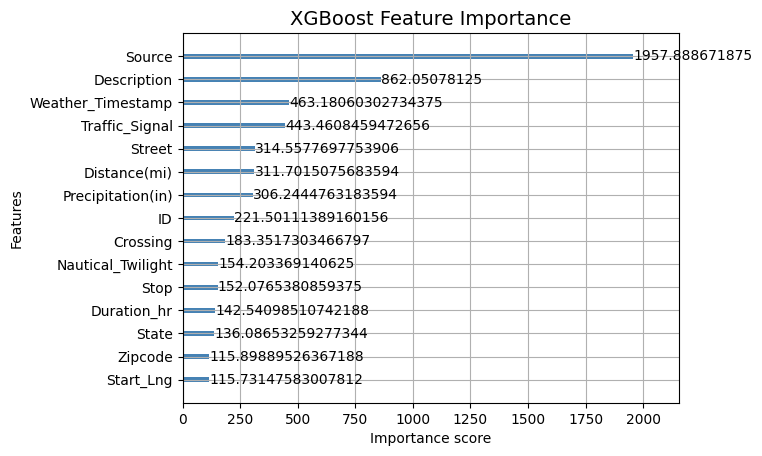

In [17]:
import xgboost as xgb
from xgboost import plot_importance

plt.figure(figsize=(10,8))
plot_importance(xgb_model, max_num_features=15, importance_type='gain', color='steelblue')
plt.title("XGBoost Feature Importance", fontsize=14)
plt.show()


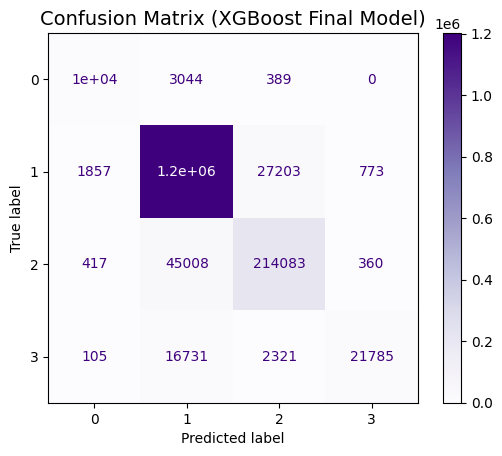

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Confusion Matrix (XGBoost Final Model)", fontsize=14)
plt.show()


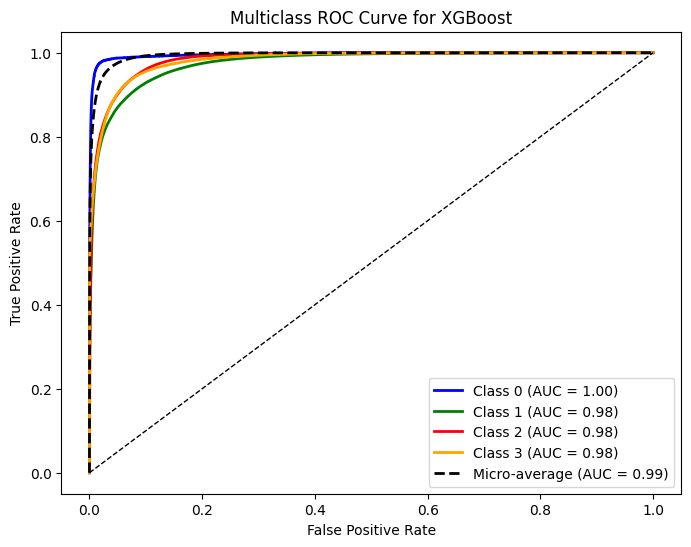

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_test and y_pred_prob are correctly shaped
n_classes = len(np.unique(y_test))

# Binarize the output (for multiclass ROC)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_score = xgb_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for all classes
plt.figure(figsize=(8,6))
colors = cycle(['blue', 'green', 'red', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

# Predict classes and probabilities
y_pred = xgb_model.predict(X_test)

# Some XGBoost versions return probabilities as DataFrame; convert safely
try:
    y_pred_prob = xgb_model.predict_proba(X_test)
except AttributeError:
    # For models without predict_proba
    y_pred_prob = np.zeros((len(y_pred), len(np.unique(y_test))))
    for i, label in enumerate(np.unique(y_test)):
        y_pred_prob[:, i] = (y_pred == label).astype(int)

# Handle ROC-AUC for multiclass safely
roc_auc = roc_auc_score(
    y_test,
    y_pred_prob,
    multi_class='ovr',
    average='weighted'
)

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Value': [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='weighted'),
        recall_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, y_pred, average='weighted'),
        roc_auc
    ]
}

df_metrics = pd.DataFrame(metrics)
display(df_metrics)


,Metric,Value
0,Accuracy,0.936463
1,Precision,0.935654
2,Recall,0.936463
3,F1-Score,0.934191
4,ROC-AUC,0.977218
